In [1]:
import os
import time
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz


t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

In [3]:
columns_quant = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']

columns_cat = ['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']

X_quant = df[columns_quant]
X_quant_scaled = StandardScaler().fit_transform(X_quant)
print(len(X_quant.columns))
display(X_quant.columns)

X_cat = df[columns_cat]
X_cat = pd.get_dummies(X_cat, columns=columns_cat, drop_first=True)
X_cat_scaled = StandardScaler().fit_transform(X_cat)
print(len(X_cat.columns))
display(X_cat.columns)

X_quant_cat = df[columns_quant + columns_cat]
X_quant_cat = pd.get_dummies(X_quant_cat, columns=columns_cat, drop_first=True)
X_quant_cat_scaled = StandardScaler().fit_transform(X_quant_cat)
print(len(X_quant_cat.columns))
display(X_quant_cat.columns)

y = df['is_display_clicked']

13


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')

50


Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')

63


Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro', 'display_env_app_ios', 'display_env_other',
       'display_env_web', 'target_env_2', 'campaignscenario_5',
       'campaignscenario_6', 'campaignscenario_11', 'campaignscenario_12',
       'campaignscenario_13', 'campaignscenario_17', 'campaignvertical_20.0',
       'campaignvertical_23.0', 'campaignvertical_129.0',
       'campaignvertical_200002.0', 'is_interstitial_True',
       'device_type_Desktop', 'device_type_Desktop - Safari',
       'device_type_Mobile - Other', 'device_type_Unknown', 'device_type_iPad',
       'device_type_iPhone', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_

In [4]:
class Modelisation():
    def __init__(self, X, y, model, scaling=True):
        self.X_columns = X.columns
        
        if scaling:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        probs = model.predict_proba(X_test)[:, 1]
        
        TP = cm[1][1]
        FN = cm[1][0]
        FP = cm[0][1]
        TN = cm[0][0]
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        # Recall
        Recall = TP/(TP+FN)
        # Precision
        Precision = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # F1_Score
        F1 = (2*Precision*Recall)/(Precision+Recall)

        metrics_score = {'f1': F1, 'recall': Recall,'negative predictive value': NPV,'precision': Precision, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
        self.recall = Recall
        

    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()     
    
    def show_metrics_score(self):
        for key, value in self.metrics_score.items():
            print(f"{key} : {value:.4f}")
            
    def show_ROC(self):
        fpr, tpr, _ = metrics.roc_curve(self.y_test, self.probs)
        plt.plot(fpr, tpr, label=f"{self.model}")
        plt.plot([0, 1], [0, 1], "r-", label='Modèle aléatoire')
        plt.plot([0, 0, 1], [0, 1, 1], 'b-', label='Modèle parfait')
        plt.legend()
        plt.title('Courbe ROC')
        plt.show()
    
    def show_attributes(self):
        # help(sklearn.tree._tree.Tree)
        tree = self.model.tree_
        attributes = {'max_depth': tree.max_depth, 'n_leaves': tree.n_leaves, 'node_count': tree.node_count}
        for key, value in attributes.items():
            print(f"{key} : {value}")
            
    def plot_tree(self):
        dot_data = tree.export_graphviz(self.model, out_file=None, 
                     feature_names=self.X_columns,  
                     class_names=['False', 'True'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
        graph = graphviz.Source(dot_data)  
        display(graph)

# Decision tree

## Variables quantitatives

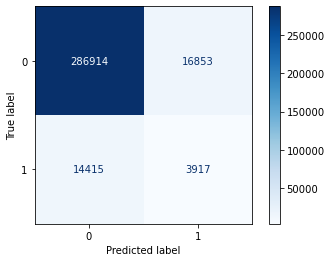

f1 : 0.2003
recall : 0.2137
negative predictive value : 0.9522
precision : 0.1886
roc_auc : 0.5791


In [5]:
m = Modelisation(X_quant, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

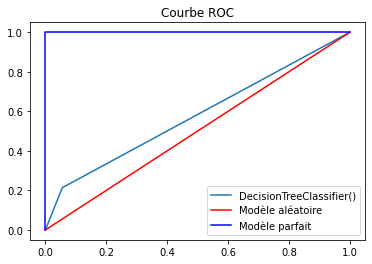

In [6]:
m.show_ROC()

In [7]:
m.show_attributes()

max_depth : 55
n_leaves : 91737
node_count : 183473


<ipython-input-4-f103a0e64527>:26: RuntimeWarning: invalid value encountered in longlong_scalars
  Precision = TP/(TP+FP)


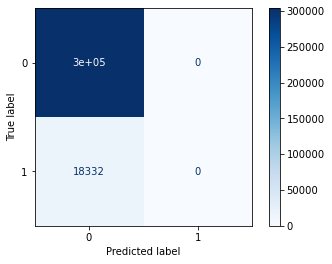

f1 : nan
recall : 0.0000
negative predictive value : 0.9431
precision : nan
roc_auc : 0.7367


In [8]:
m = Modelisation(X_quant, y, DecisionTreeClassifier(max_depth=2))
m.show_conf_matrix()
m.show_metrics_score()

In [9]:
m.show_attributes()

max_depth : 2
n_leaves : 4
node_count : 7


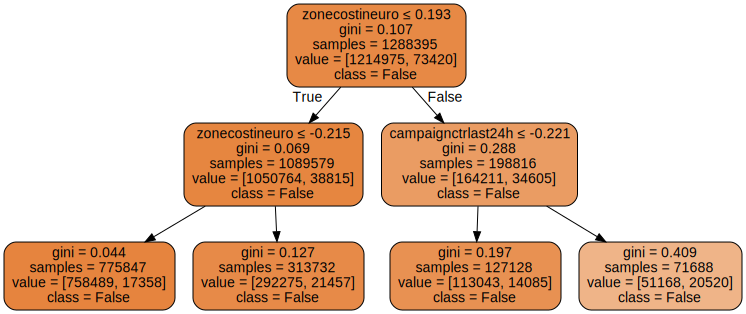

In [10]:
m.plot_tree()

## Categorical variables

In [11]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


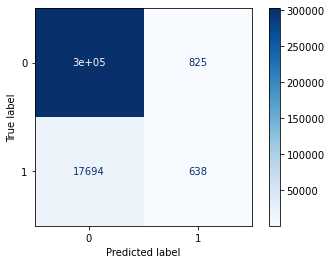

f1 : 0.0645
recall : 0.0348
negative predictive value : 0.9448
precision : 0.4361
roc_auc : 0.6569


In [12]:
m = Modelisation(X_cat, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [13]:
m.show_attributes()

max_depth : 47
n_leaves : 19750
node_count : 39499


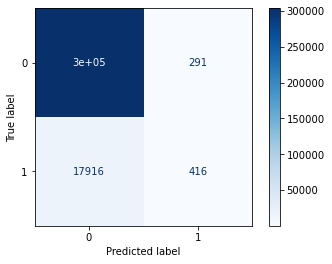

f1 : 0.0437
recall : 0.0227
negative predictive value : 0.9443
precision : 0.5884
roc_auc : 0.6768


In [14]:
m = Modelisation(X_cat, y, DecisionTreeClassifier(max_depth=5))
m.show_conf_matrix()
m.show_metrics_score()

In [15]:
m.show_attributes()

max_depth : 5
n_leaves : 31
node_count : 61


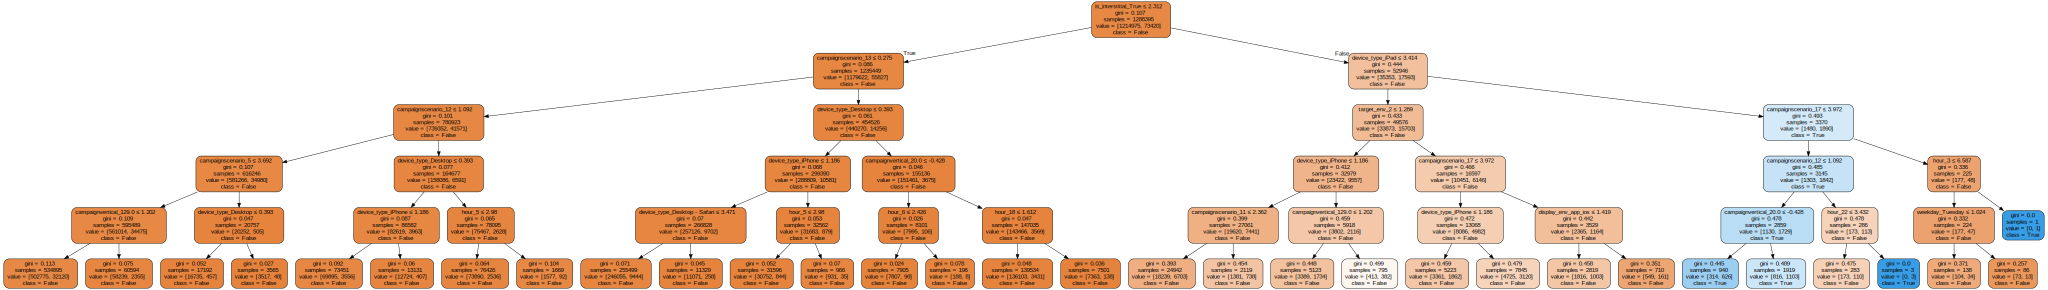

In [16]:
m.plot_tree()

## Quantitative + categorical

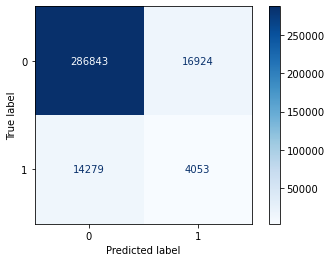

f1 : 0.2062
recall : 0.2211
negative predictive value : 0.9526
precision : 0.1932
roc_auc : 0.5827
Wall time: 50 s


In [17]:
%%time
m = Modelisation(X_quant_cat, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [18]:
m.show_attributes()

max_depth : 56
n_leaves : 87567
node_count : 175133


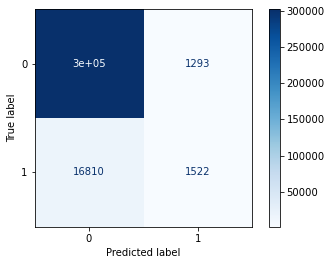

f1 : 0.1439
recall : 0.0830
negative predictive value : 0.9474
precision : 0.5407
roc_auc : 0.7840


In [19]:
m = Modelisation(X_quant_cat, y, DecisionTreeClassifier(max_depth=4))
m.show_conf_matrix()
m.show_metrics_score()

In [20]:
m.show_attributes()

max_depth : 4
n_leaves : 16
node_count : 31


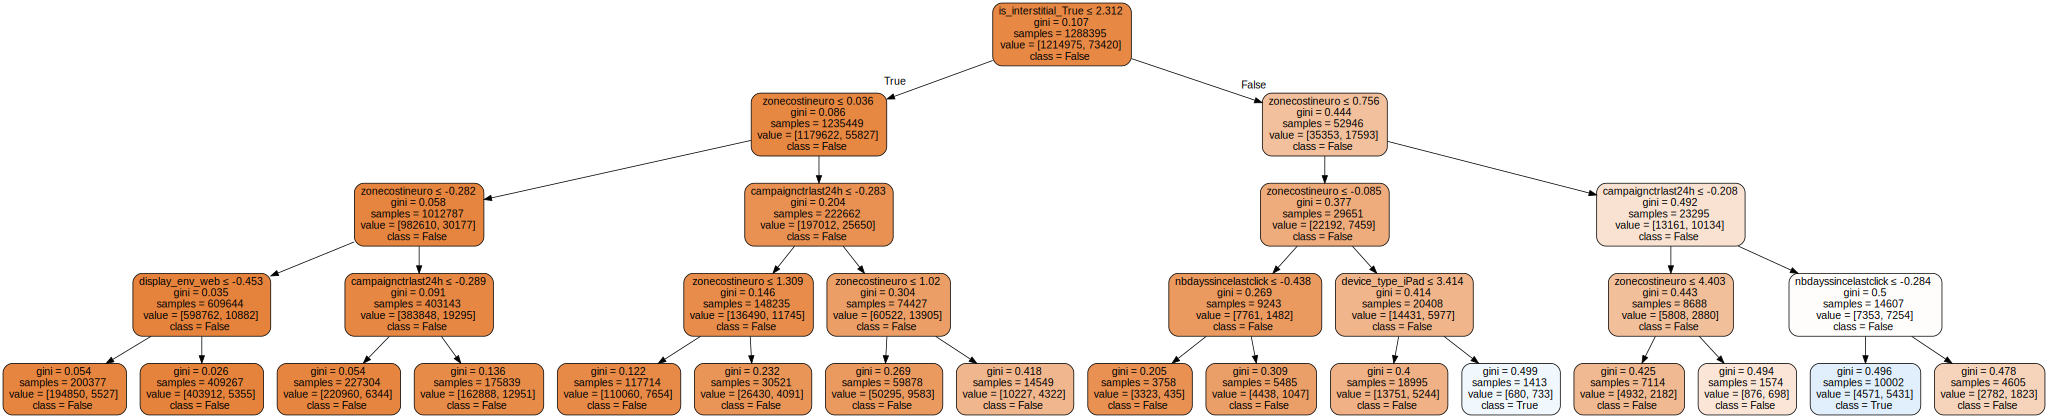

In [21]:
m.plot_tree()

# Random Forest

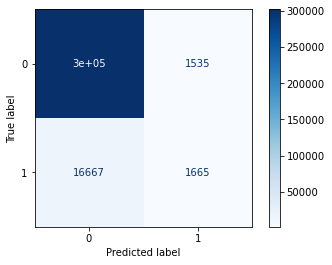

f1 : 0.1547
recall : 0.0908
negative predictive value : 0.9477
precision : 0.5203
roc_auc : 0.7344
Wall time: 27.1 s


In [22]:
%%time
m = Modelisation(X_quant_cat, y, RandomForestClassifier(n_estimators=10, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

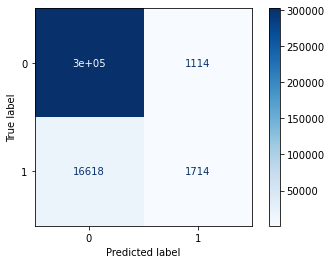

f1 : 0.1620
recall : 0.0935
negative predictive value : 0.9480
precision : 0.6061
roc_auc : 0.8131
Wall time: 2min 47s


In [23]:
%%time
m = Modelisation(X_quant_cat, y, RandomForestClassifier(n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

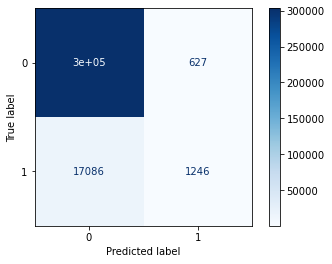

f1 : 0.1233
recall : 0.0680
negative predictive value : 0.9466
precision : 0.6652
roc_auc : 0.8344
Wall time: 2min 34s


In [24]:
%%time
m = Modelisation(X_quant_cat, y, RandomForestClassifier(min_samples_leaf=15, n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

In [25]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:08:21
